In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box

In [2]:
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

In [3]:
env_name='CartPole-v0'
hidden_sizes=[32]
lr=1e-2
epochs=500
batch_size=5000
render=False

# make environment, check spaces, get obs / act dims
env = gym.make(env_name)
assert isinstance(env.observation_space, Box), \
    "This example only works for envs with continuous state spaces."
assert isinstance(env.action_space, Discrete), \
    "This example only works for envs with discrete action spaces."

obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

# make core of policy network
logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

# make function to compute action distribution
def get_policy(obs):
    logits = logits_net(obs)
    return Categorical(logits=logits)

# make action selection function (outputs int actions, sampled from policy)
def get_action(obs):
    return get_policy(obs).sample().item()

# make loss function whose gradient, for the right data, is policy gradient
def compute_loss(obs, act, weights):
    logp = get_policy(obs).log_prob(act)
    return -(logp * weights).mean()

# make optimizer
optimizer = Adam(logits_net.parameters(), lr=lr)


/home/ankdesh/virtualenvs/spinningup/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# for training policy
def train_one_epoch():
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths

    # reset episode-specific variables
    obs = env.reset()       # first obs comes from starting distribution
    done = False            # signal from environment that episode is over
    ep_rews = []            # list for rewards accrued throughout ep

    # render first episode of each epoch
    finished_rendering_this_epoch = False

    # collect experience by acting in the environment with current policy
    while True:

        # rendering
        if (not finished_rendering_this_epoch) and render:
            env.render()

        # save obs
        batch_obs.append(obs.copy())

        # act in the environment
        act = get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, rew, done, _ = env.step(act)

        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)
        
        if done:
            
            #max_x = max(list(zip(*batch_obs))[0])
            #print (batch_obs[0], len(batch_obs))
            #print (max_x)
            # if episode is over, record info about episode
            ep_ret, ep_len = sum(ep_rews), len(ep_rews)
            
            #if max_x > -0.2:
            #    ep_ret = 1
            
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            # the weight for each logprob(a|s) is R(tau)
            batch_weights += [ep_ret] * ep_len
            #batch_weights += 
            
            # reset episode-specific variables
            obs, done, ep_rews = env.reset(), False, []

            # won't render again this epoch
            finished_rendering_this_epoch = True

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break

    #print (len(batch_obs) , len(batch_acts))
    #print (batch_obs[0], batch_acts[0])
    # take a single policy gradient update step
    optimizer.zero_grad()
    batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                              act=torch.as_tensor(batch_acts, dtype=torch.int32),
                              weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                              )
    batch_loss.backward()
    optimizer.step()
    return batch_loss, batch_rets, batch_lens, batch_obs

In [5]:
batch_loss, batch_rets, batch_lens, batch_obs = train_one_epoch()

In [6]:
# training loop
logs = []
for i in range(epochs):
    batch_loss, batch_rets, batch_lens,_ = train_one_epoch()
    logs.append((batch_loss, batch_rets, batch_lens))
    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
            (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

epoch:   0 	 loss: 16.409 	 return: 19.475 	 ep_len: 19.475
epoch:   1 	 loss: 19.286 	 return: 22.833 	 ep_len: 22.833
epoch:   2 	 loss: 23.337 	 return: 25.571 	 ep_len: 25.571
epoch:   3 	 loss: 27.398 	 return: 29.357 	 ep_len: 29.357
epoch:   4 	 loss: 28.783 	 return: 32.335 	 ep_len: 32.335
epoch:   5 	 loss: 33.478 	 return: 38.359 	 ep_len: 38.359
epoch:   6 	 loss: 37.344 	 return: 40.040 	 ep_len: 40.040
epoch:   7 	 loss: 38.722 	 return: 44.611 	 ep_len: 44.611
epoch:   8 	 loss: 37.526 	 return: 48.154 	 ep_len: 48.154
epoch:   9 	 loss: 46.562 	 return: 56.000 	 ep_len: 56.000
epoch:  10 	 loss: 42.044 	 return: 51.588 	 ep_len: 51.588
epoch:  11 	 loss: 48.900 	 return: 60.590 	 ep_len: 60.590
epoch:  12 	 loss: 53.745 	 return: 68.589 	 ep_len: 68.589
epoch:  13 	 loss: 56.528 	 return: 76.303 	 ep_len: 76.303
epoch:  14 	 loss: 59.870 	 return: 79.635 	 ep_len: 79.635
epoch:  15 	 loss: 65.730 	 return: 86.102 	 ep_len: 86.102
epoch:  16 	 loss: 55.599 	 return: 79.6

epoch: 133 	 loss: 66.148 	 return: 197.923 	 ep_len: 197.923
epoch: 134 	 loss: 68.728 	 return: 200.000 	 ep_len: 200.000
epoch: 135 	 loss: 68.264 	 return: 200.000 	 ep_len: 200.000
epoch: 136 	 loss: 68.600 	 return: 200.000 	 ep_len: 200.000
epoch: 137 	 loss: 65.843 	 return: 198.115 	 ep_len: 198.115
epoch: 138 	 loss: 68.290 	 return: 200.000 	 ep_len: 200.000
epoch: 139 	 loss: 68.563 	 return: 200.000 	 ep_len: 200.000
epoch: 140 	 loss: 68.289 	 return: 198.692 	 ep_len: 198.692
epoch: 141 	 loss: 68.060 	 return: 198.731 	 ep_len: 198.731
epoch: 142 	 loss: 69.274 	 return: 199.808 	 ep_len: 199.808
epoch: 143 	 loss: 67.439 	 return: 200.000 	 ep_len: 200.000
epoch: 144 	 loss: 66.356 	 return: 200.000 	 ep_len: 200.000
epoch: 145 	 loss: 67.833 	 return: 200.000 	 ep_len: 200.000
epoch: 146 	 loss: 68.753 	 return: 199.577 	 ep_len: 199.577
epoch: 147 	 loss: 67.397 	 return: 199.423 	 ep_len: 199.423
epoch: 148 	 loss: 69.902 	 return: 200.000 	 ep_len: 200.000
epoch: 1

epoch: 266 	 loss: 75.553 	 return: 197.615 	 ep_len: 197.615
epoch: 267 	 loss: 78.780 	 return: 200.000 	 ep_len: 200.000
epoch: 268 	 loss: 80.075 	 return: 198.538 	 ep_len: 198.538
epoch: 269 	 loss: 80.104 	 return: 200.000 	 ep_len: 200.000
epoch: 270 	 loss: 80.199 	 return: 200.000 	 ep_len: 200.000
epoch: 271 	 loss: 78.938 	 return: 199.769 	 ep_len: 199.769
epoch: 272 	 loss: 81.055 	 return: 199.885 	 ep_len: 199.885
epoch: 273 	 loss: 81.480 	 return: 198.385 	 ep_len: 198.385
epoch: 274 	 loss: 82.480 	 return: 199.808 	 ep_len: 199.808
epoch: 275 	 loss: 84.608 	 return: 200.000 	 ep_len: 200.000
epoch: 276 	 loss: 83.428 	 return: 198.962 	 ep_len: 198.962
epoch: 277 	 loss: 83.679 	 return: 200.000 	 ep_len: 200.000
epoch: 278 	 loss: 84.898 	 return: 200.000 	 ep_len: 200.000
epoch: 279 	 loss: 85.534 	 return: 200.000 	 ep_len: 200.000
epoch: 280 	 loss: 84.935 	 return: 198.615 	 ep_len: 198.615
epoch: 281 	 loss: 86.540 	 return: 200.000 	 ep_len: 200.000
epoch: 2

epoch: 398 	 loss: 84.050 	 return: 183.286 	 ep_len: 183.286
epoch: 399 	 loss: 85.498 	 return: 192.333 	 ep_len: 192.333
epoch: 400 	 loss: 84.862 	 return: 190.926 	 ep_len: 190.926
epoch: 401 	 loss: 83.114 	 return: 182.321 	 ep_len: 182.321
epoch: 402 	 loss: 88.267 	 return: 191.593 	 ep_len: 191.593
epoch: 403 	 loss: 85.860 	 return: 185.778 	 ep_len: 185.778
epoch: 404 	 loss: 88.169 	 return: 195.808 	 ep_len: 195.808
epoch: 405 	 loss: 87.057 	 return: 191.593 	 ep_len: 191.593
epoch: 406 	 loss: 86.456 	 return: 189.852 	 ep_len: 189.852
epoch: 407 	 loss: 87.839 	 return: 198.346 	 ep_len: 198.346
epoch: 408 	 loss: 90.110 	 return: 199.885 	 ep_len: 199.885
epoch: 409 	 loss: 90.549 	 return: 196.462 	 ep_len: 196.462
epoch: 410 	 loss: 90.387 	 return: 195.192 	 ep_len: 195.192
epoch: 411 	 loss: 90.807 	 return: 199.769 	 ep_len: 199.769
epoch: 412 	 loss: 89.305 	 return: 196.346 	 ep_len: 196.346
epoch: 413 	 loss: 91.099 	 return: 200.000 	 ep_len: 200.000
epoch: 4

In [7]:
print (len(logs), logs[0][0], len(logs[0][1]), len(logs[0][2]))

500 tensor(16.4088, grad_fn=<NegBackward>) 257 257


In [8]:
returns = list(zip(*logs))[1]

In [9]:
import matplotlib.pyplot as plt

In [10]:
mean_returns = [np.mean(x) for x in returns]

In [11]:
print (mean_returns)

[19.474708171206224, 22.832579185520363, 25.571428571428573, 29.35672514619883, 32.33548387096774, 38.3587786259542, 40.04, 44.610619469026545, 48.15384615384615, 56.0, 51.58762886597938, 60.59036144578313, 68.58904109589041, 76.3030303030303, 79.63492063492063, 86.10169491525424, 79.671875, 90.94545454545455, 102.3265306122449, 103.74, 118.04651162790698, 120.4047619047619, 127.35, 146.17142857142858, 159.90625, 142.86111111111111, 175.48275862068965, 184.35714285714286, 175.44827586206895, 179.92857142857142, 172.68965517241378, 182.96428571428572, 177.93103448275863, 172.44827586206895, 167.5, 170.66666666666666, 182.35714285714286, 184.75, 189.07407407407408, 178.92857142857142, 186.25925925925927, 189.59259259259258, 198.69230769230768, 192.3846153846154, 189.8148148148148, 177.93103448275863, 183.64285714285714, 178.71428571428572, 178.0344827586207, 187.33333333333334, 176.6206896551724, 184.71428571428572, 175.24137931034483, 188.33333333333334, 185.67857142857142, 177.27586206

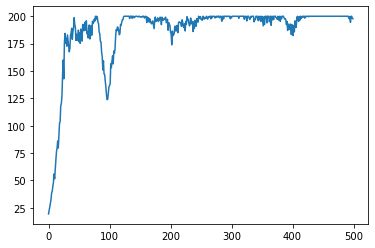

In [12]:
plt.plot(mean_returns)